## Intro to TectModel

In [38]:
#load in parent stuff

import nb_load_stuff
from tectModelClass import *

In [39]:
#If run through Docker we'll point at the local 'unsupported dir.'
#On hpc, the path should also include a directory holding the unsupported_dan.
import os
import sys

if os.getcwd() == '/workspace/newSlab':
    sys.path.append('../unsupported')

#this does't actually need to be protected. More a reminder it's an interim measure
try:
    sys.path.append('../unsupported')
except:
    pass

In [40]:
from unsupported_dan.utilities import *
from unsupported_dan.utilities import *
from unsupported_dan.interfaces.marker2D import markerLine2D, line_collection


In [41]:
import numpy as np
import underworld as uw
from underworld import function as fn
import glucifer
from easydict import EasyDict as edict
import networkx as nx
import operator




## Toy model

In [42]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1"), 
                                 elementRes  = (96, 48), 
                                 minCoord    = (-1.0, 0.0), 
                                 maxCoord    = (1.0, 1.0) )


temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
velocityField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=2 )
coordinate = fn.input()


In [43]:
#toy model, 3 plates
############################
#-1        0.0  0.5    1.0
######1##### ###2###  ##3##
            #
             #
###########################

tg = TectModel(mesh, 0, 20, 1)

tg.add_plate(1, velocities = 1)
tg.add_plate(2,velocities = -1)
tg.add_plate(3, velocities = 0)
        
tg.add_left_boundary(1)
tg.add_subzone(1, 2, 0.0, subInitAge=50.0, upperInitAge=10.0)
tg.add_ridge(2, 3, 0.5)
tg.add_right_boundary(3, 30.)

In [44]:

tg.is_subduction_boundary((1,2))

True

In [45]:
#tg.is_subduction_boundary(2,1), tg.is_subduction_boundary(3,2)

#tg.subduction_boundary_from_plate(3)
#tg.is_subducting_plate(1)
#
#np.sort(tg.get_boundaries(1)).mean(),  np.sort(tg.get_boundaries(2)).mean()
#tg.subduction_direction(1,2)

#tg.subduction_boundary_from_plate(tg.subduction_direction(2,1))
#tg.subduction_boundary_from_plate(tg.subduction_edge_order(2,1)[0])

In [46]:
plateId =1
len(tg[plateId].keys()) == 1 and len(tg.undirected[plateId].keys()) ==2

False

In [47]:
plateId = 3
for b in tg.connected_plates(plateId ):
    print(b)
    if tg.has_edge(plateId, b) and tg.has_edge(b, plateId):
        pass
    else:
        print(tg.subduction_direction(plateId, b))
        break

2
3


In [48]:
plateId = 2
[i for i in tg.out_edges(plateId)]
#[i for i in tg.in_edges(plateId)]


[(2, 3)]

In [49]:
tg.in_edges(plateId)[0], tg.out_edges(plateId)[0]

((1, 2), (2, 3))

In [56]:
#pAgeDict

{0: <underworld.function.misc.constant at 0x7fc9a75cc810>,
 1: <underworld.function._function.add at 0x7fc9a9621f90>,
 2: <underworld.function._function.add at 0x7fc9a9626690>,
 3: <underworld.function._function.add at 0x7fc9a9626d50>}


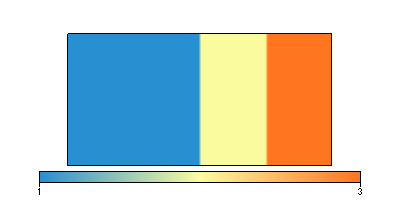

In [50]:
#for n in tg.nodes():
#    print(n)
#    bounds  = np.sort(tg.get_boundaries(n))
#    print('plate {}'.format(n), bounds)
    
    
pIdFn = tg.plate_id_fn()
pAgeDict = tg.plate_age_fn() 

fnAge_map = fn.branching.map(fn_key = pIdFn , 
                          mapping = pAgeDict )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, pIdFn ))
fig.show()

In [51]:
#combMaskFn = operator.or_(RboundMaskFn, SboundMaskFn )


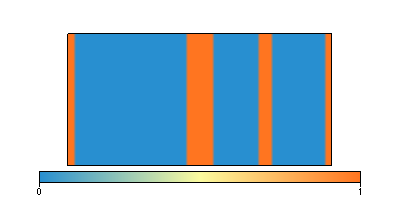

In [52]:
boundMaskFn = tg.plate_boundary_mask_fn(0.1)
RboundMaskFn = tg.ridge_mask_fn(0.05)
SboundMaskFn = tg.subduction_mask_fn(0.1)

#We can 'add' these mask functions like so
boundMaskFn = tg.combine_mask_fn(RboundMaskFn, SboundMaskFn )

fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, boundMaskFn ))
fig.show()

In [55]:
#boundMaskFn.evaluate(mesh)


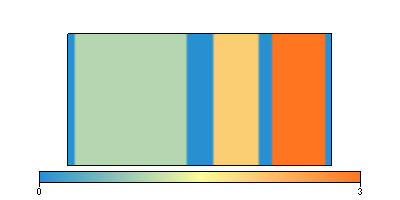

In [37]:
#We can also have  masked Plate Function 

maskedPlateIdFn = tg.plate_id_fn(maskFn=boundMaskFn)
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, maskedPlateIdFn , valueRange = [0, 3] ))
fig.show()

In [17]:
#loc = tg.get_edge_data( *tg.edges()[0])['loc']
#velocityField.evaluate_global((loc,1.0))

In [18]:
tg.nodes(), tg.edges()


([1, 2, 3], [(1, 1), (1, 2), (2, 3), (3, 2), (3, 3)])

In [19]:
#uw.systems.SwarmAdvector?

In [20]:

#We can traverse the undirect graph and use these functions to query the underlying directed data structue
for e in tg.undirected.edges():
    print(tg.is_ridge(e), tg.is_subduction_boundary(e))
    e = (e[1], e[0])
    print(tg.is_ridge(e), tg.is_subduction_boundary(e))

(True, False)
(True, False)
(False, True)
(False, True)
(True, False)
(True, False)
(True, False)
(True, False)



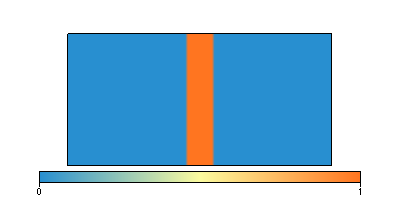

In [24]:
#Can also specify a single plate boundary

boundMaskFn2 = tg.plate_boundary_mask_fn(0.1, bound=(1,2))


fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, boundMaskFn2 ))
fig.show()

## Integration test

In [26]:
velocityField.data[:,0] =   tg.xFn.evaluate(mesh)[:,0] - tg.minX


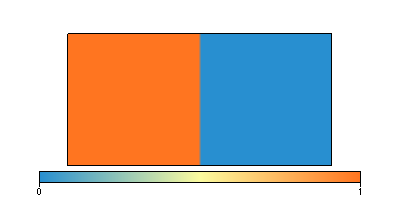

In [29]:
fig = glucifer.Figure(figsize=(400, 200))
fig.append( glucifer.objects.Surface(tg.mesh, fn2 ))
fig.show()

In [35]:
#_surfLength  = uw.utils.Integral( boundMaskFn2, mesh=mesh, integrationType='Surface', surfaceIndexSet=tWalls)
#surfLength = _surfLength.evaluate()

In [30]:
#Setup some mask Fns

conds1 = [ (         tg.xFn > 0.5,  1.),
                   (                                                   True , 0.) ]


conds2 = [ (         tg.xFn <= 0,  1.),
                   (       True , 0.) ]

fn1 = fn.branching.conditional(conds1 )
fn2 = fn.branching.conditional(conds2)


fnvector = [fn1, fn2]

In [31]:
tWalls=mesh.specialSets["MaxJ_VertexSet"]
_surfLength  = uw.utils.Integral( fnvector, mesh=mesh, integrationType='Surface', surfaceIndexSet=tWalls)
surfLength = _surfLength.evaluate()

In [32]:
surfLength

[0.5000000000000003, 1.000000000000001]

In [33]:
#_mmVxSurf = fn.view.min_max(fn1, fn_auxiliary=tg.xFn )
#dummyFn = _mmVxSurf.evaluate(tWalls)

In [38]:
#_mmVxSurf.max_global(), _mmVxSurf.max_global_auxiliary()

In [28]:
testFn = tg.xFn <= 0

In [32]:
test2 = operator.and_(testFn, testFn )

In [ ]:
operator.